In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
#Self Decision Tree Algorithm
class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or num_classes == 1:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}

        best_split = None
        best_gain = 0.0

        # Calculate the entropy (or Gini impurity) of the current node
        current_entropy = self._entropy(y)

        # Iterate over each feature to find the best split
        for feature_idx in range(num_features):
            feature_values = np.unique(X[:, feature_idx])

            if len(feature_values) > 10:  # Assuming a feature is continuous if it has more than 10 unique values
                # Continuous feature: Use Reduction of Variance to find the best split point
                sorted_idx = np.argsort(X[:, feature_idx])
                for i in range(1, len(sorted_idx)):
                    if X[sorted_idx[i], feature_idx] != X[sorted_idx[i - 1], feature_idx]:
                        split_value = (X[sorted_idx[i], feature_idx] + X[sorted_idx[i - 1], feature_idx]) / 2.0
                        X_left, y_left, X_right, y_right = self._split_continuous(X, y, feature_idx, split_value)
                        gain = self._variance_reduction(y, y_left, y_right)
                        if gain > best_gain:
                            best_gain = gain
                            best_split = {'feature_idx': feature_idx, 'split_value': split_value,
                                          'X_left': X_left, 'y_left': y_left,
                                          'X_right': X_right, 'y_right': y_right}
            else:
                # Categorical feature: Use Information Gain to find the best split
                for value in feature_values:
                    X_subset, y_subset = self._split_categorical(X, y, feature_idx, value)
                    gain = self._information_gain(current_entropy, [y_subset, y[~(X[:, feature_idx] == value)]])
                    if gain > best_gain:
                        best_gain = gain
                        best_split = {'feature_idx': feature_idx, 'value': value,
                                      'X_subset': X_subset, 'y_subset': y_subset}

        if best_split is None:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}

        if 'split_value' in best_split:
            # Continuous split
            left_subtree = self._grow_tree(best_split['X_left'], best_split['y_left'], depth + 1)
            right_subtree = self._grow_tree(best_split['X_right'], best_split['y_right'], depth + 1)
            return {'leaf': False, 'feature_idx': best_split['feature_idx'],
                    'split_value': best_split['split_value'],
                    'left': left_subtree, 'right': right_subtree}
        else:
            # Categorical split
            remaining_X = X[~(X[:, best_split['feature_idx']] == best_split['value'])]
            remaining_y = y[~(X[:, best_split['feature_idx']] == best_split['value'])]
            subset_tree = self._grow_tree(best_split['X_subset'], best_split['y_subset'], depth + 1)
            remaining_tree = self._grow_tree(remaining_X, remaining_y, depth + 1)
            return {'leaf': False, 'feature_idx': best_split['feature_idx'], 'value': best_split['value'],
                    'subset': subset_tree, 'remaining': remaining_tree}

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _information_gain(self, parent_entropy, subsets):
        total = sum(len(subset) for subset in subsets)
        gain = parent_entropy - sum((len(subset) / total) * self._entropy(subset) for subset in subsets)
        return gain

    def _split_categorical(self, X, y, feature_idx, value):
        mask = X[:, feature_idx] == value
        return X[mask], y[mask]

    def _variance_reduction(self, parent, left, right):
        total_var = np.var(parent)
        left_var = np.var(left) if len(left) > 0 else 0
        right_var = np.var(right) if len(right) > 0 else 0
        total_size = len(left) + len(right)
        reduction = total_var - ((len(left) / total_size) * left_var + (len(right) / total_size) * right_var)
        return reduction

    def _split_continuous(self, X, y, feature_idx, split_value):
        mask_left = X[:, feature_idx] <= split_value
        mask_right = X[:, feature_idx] > split_value
        return X[mask_left], y[mask_left], X[mask_right], y[mask_right]

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, node):
        if node['leaf']:
            return node['class']
        else:
            if 'split_value' in node:
                # Continuous split
                if x[node['feature_idx']] <= node['split_value']:
                    return self._predict_tree(x, node['left'])
                else:
                    return self._predict_tree(x, node['right'])
            else:
                # Categorical split
                if x[node['feature_idx']] == node['value']:
                    return self._predict_tree(x, node['subset'])
                else:
                    return self._predict_tree(x, node['remaining'])  # Follow the remaining tree

In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kagglee.json ~/.kaggle/
!chmod 600 ~/.kaggle/kagglee.json

#Data Collection:

**Import dataset from kaggle**

Dataset URL: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

In [6]:
!kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data
!unzip fraudulent-transactions-data.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data
License(s): CC0-1.0
 97% 173M/178M [00:01<00:00, 116MB/s]
100% 178M/178M [00:01<00:00, 107MB/s]
Archive:  fraudulent-transactions-data.zip
  inflating: /content/Fraud.csv      


**Load dataset**

In [7]:
data =  pd.read_csv('/content/Fraud.csv')

**Check first five rows**

In [8]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Shape of dataset**

In [9]:
data.shape
print('Number of rows:', data.shape[0])
print('Number of columns:', data.shape[1])

Number of rows: 6362620
Number of columns: 11


**Dataset information**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


**Basic data statistics**

In [11]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


#Data Preprocessing:

**Null values count**

In [12]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**Check duplicates**

In [13]:
data.duplicated().sum()

0

**Exploring transaction type**

In [14]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of legit & fraudulent transaction')

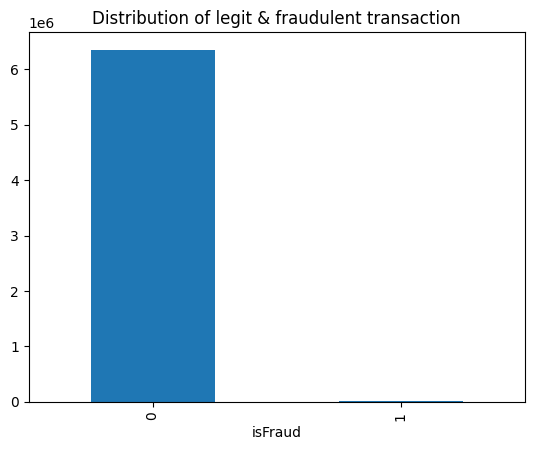

In [15]:
data['isFraud'].value_counts().plot(kind='bar').set_title('Distribution of legit & fraudulent transaction')

Dataset is highly unbalanced

*   0: Legit Transaction
*   1: Fraud Transaction



In [16]:
legit = data[data.isFraud == 0]
fraud = data[data.isFraud == 1]

In [17]:
legit.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

**Distribution of legit & fraudulent transaction**

In [18]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

**Compare values of legit & fraud transaction**

In [19]:
# data.groupby('isFraud').mean()

In [20]:
numerical_features = [i for i in data.columns if data[i].dtype == 'int64'or data[i].dtype =='int32' or data[i].dtype =='float64']
categorical_features = [i for i in data.columns if data[i].dtype == 'object']

**Numerical Features**

In [21]:
numerical_features

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

**Categorical Features**

In [22]:
categorical_features

['type', 'nameOrig', 'nameDest']

**Encode categorical features**

In [23]:
le = LabelEncoder()
for categorical_feature in categorical_features:
  data[categorical_feature] = le.fit_transform(data[categorical_feature])
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


#Explporatory Data Analysis (EDA):

**Transaction Type Distribution**

In [24]:
data.type.value_counts()

type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64

In [25]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(data,
             values=quantity,
             names=transactions,hole = 0.5,
             title="Distribution of Transaction Type")
figure.show()

* 0: CASH_IN  
* 1: CASH_OUT   
* 2: DEBIT      
* 3: PAYMENT  
* 4: TRANSFER    




**Numerical Features Distribution**

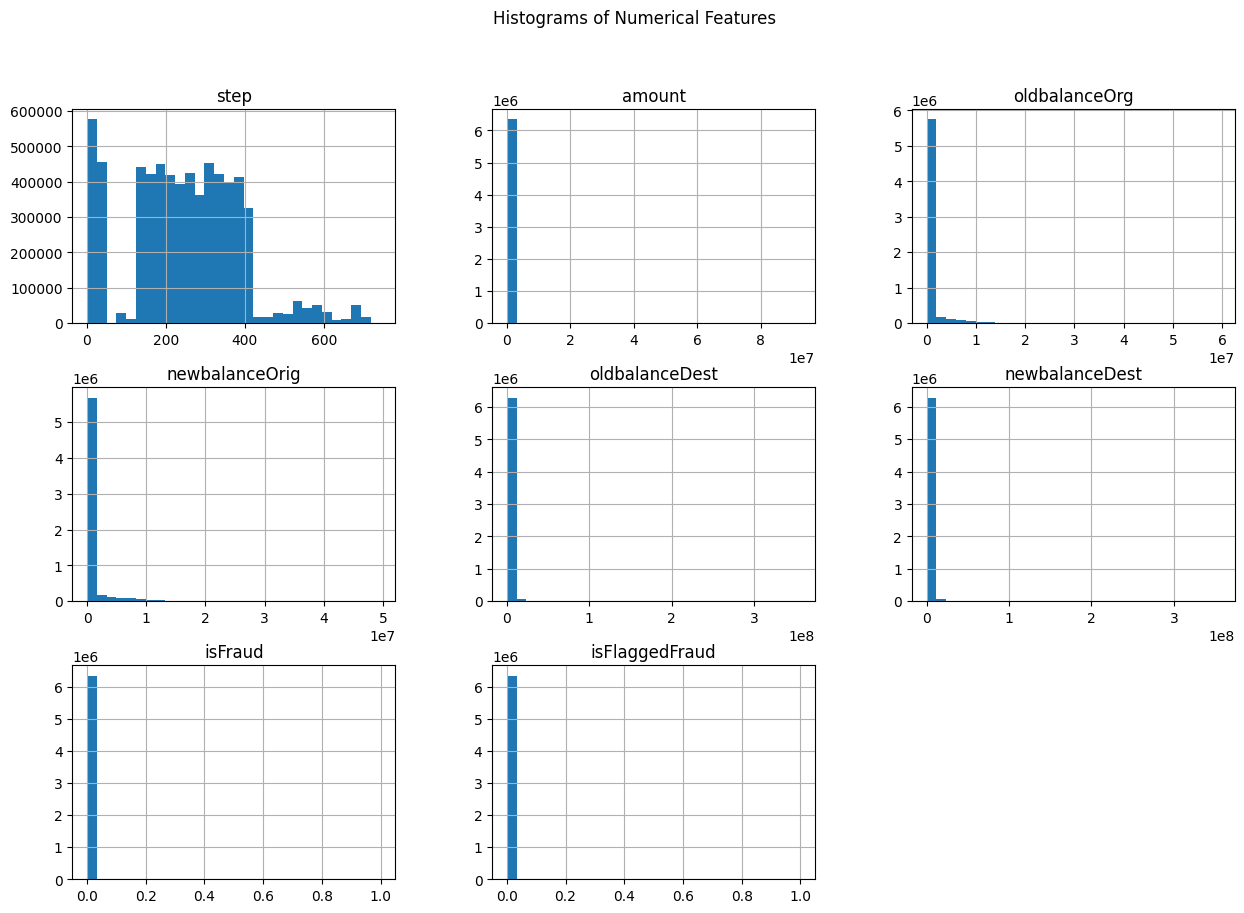

In [26]:
data[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

**Correlation Between Features**

In [27]:
# Compute the correlation matrix
correlation_matrix = data.corr()

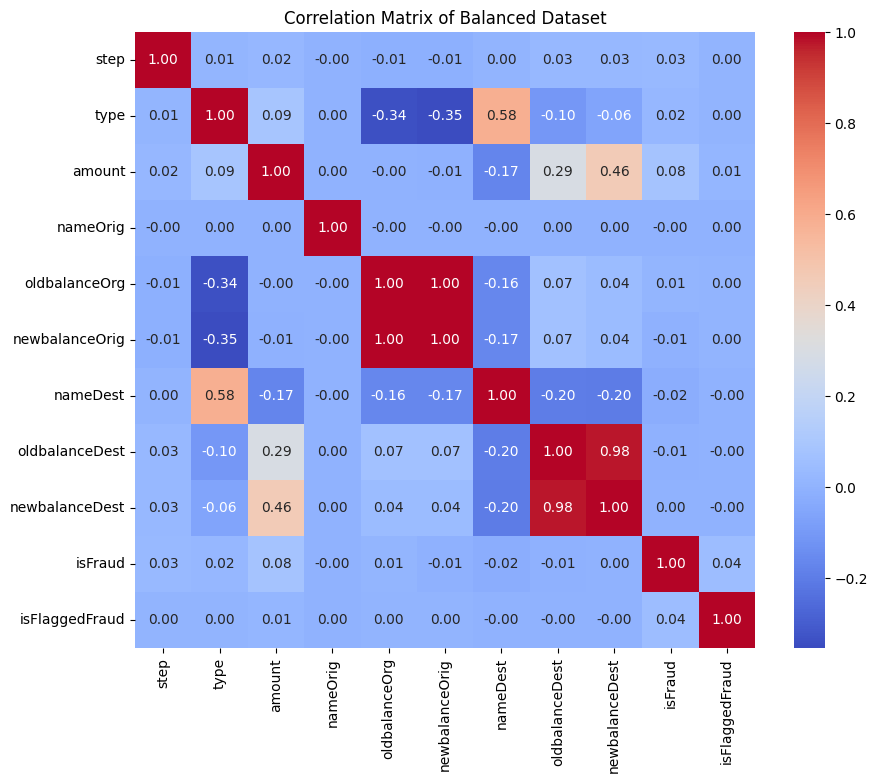

In [28]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Balanced Dataset')
plt.show()

This shows the relationship between fraud transaction & other features.

* It can be seen that nameOrig, newbalanceOrig, oldbalanceDest, nameDest are negatively related with isFraud.
* Similarly, newbalanceOrig, oldbalanceOrig & newbalanceDest, oldbalanceDest are highly related


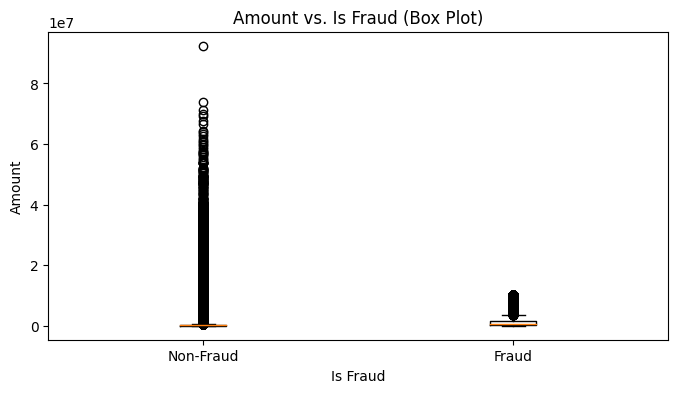

In [29]:
plt.figure(figsize=(8, 4))

# Prepare data for box plot
fraud_data = [data[data['isFraud'] == label]['amount'] for label in [0, 1]]

# Plot
plt.boxplot(fraud_data, labels=['Non-Fraud', 'Fraud'])
plt.title('Amount vs. Is Fraud (Box Plot)')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')

plt.show()

#Feature Engineering:

**Dropping Irrelvent attributes**

In [30]:
columns_dropped = [ "step","nameOrig", "nameDest", "oldbalanceDest", "newbalanceDest", "isFlaggedFraud"]
reduced_data = data.drop(columns = columns_dropped)
reduced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,3,9839.64,170136.0,160296.36,0
1,3,1864.28,21249.0,19384.72,0
2,4,181.00,181.0,0.00,1
3,1,181.00,181.0,0.00,1
4,3,11668.14,41554.0,29885.86,0


**Adding New Feature**

In [31]:
reduced_data['deltabalanceOrig'] = reduced_data['oldbalanceOrg'] - reduced_data['newbalanceOrig']
reduced_data['deltabalanceDest'] = data['newbalanceDest'] - data['oldbalanceDest']

reduced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,deltabalanceOrig,deltabalanceDest
0,3,9839.64,170136.0,160296.36,0,9839.64,0.0
1,3,1864.28,21249.0,19384.72,0,1864.28,0.0
2,4,181.00,181.0,0.00,1,181.00,0.0
3,1,181.00,181.0,0.00,1,181.00,-21182.0
4,3,11668.14,41554.0,29885.86,0,11668.14,0.0


**Scale Numerical Features**

In [32]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
reduced_data[['amount', 'oldbalanceOrg', 'newbalanceOrig','deltabalanceOrig', 'deltabalanceDest']] = scaler.fit_transform(reduced_data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'deltabalanceOrig','deltabalanceDest']])

# Display the scaled features
reduced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,deltabalanceOrig,deltabalanceDest
0,3,-0.281560,-0.229810,-0.237622,0,0.211876,-0.152896
1,3,-0.294767,-0.281359,-0.285812,0,0.157490,-0.152896
2,4,-0.297555,-0.288654,-0.292442,1,0.146011,-0.152896
3,1,-0.297555,-0.288654,-0.292442,1,0.146011,-0.178952
4,3,-0.278532,-0.274329,-0.282221,0,0.224345,-0.152896


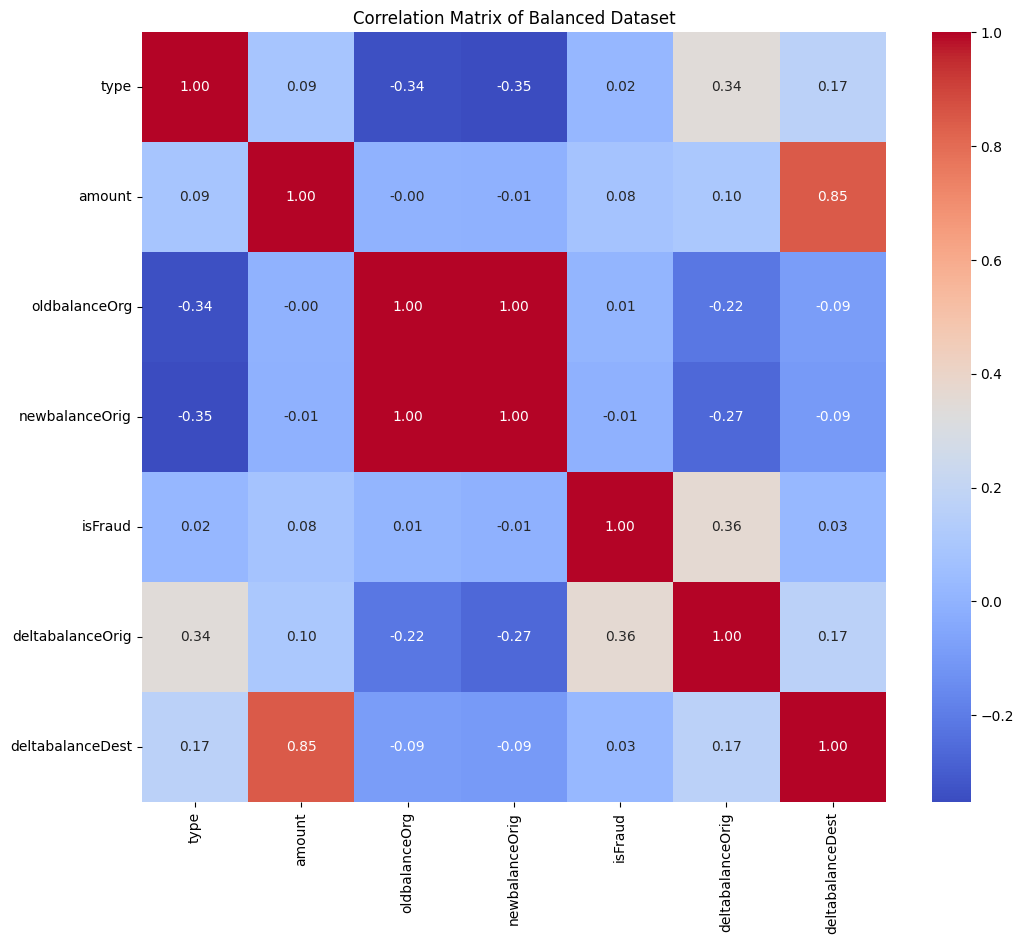

In [33]:
reduced_data.head()
cor = reduced_data.corr()
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Balanced Dataset')
plt.show()

###Balancing of Dataset
  
  Since our dataset is highly unbalanced. Therefore, we need to balance it. There are two ways of balancing the dataset
*   Undersampling
*   Oversampling



#### Under Sampling Dataset

Since the dataset is highly unbalanced. Legit transaction record is significantly larger than fraudulant transaction. We have 8213 fraud transaction record that is enough for training and testing our. Due to computational/memory limit, we have used undersampling technique.

In [44]:
legit = reduced_data[data.isFraud == 0]
fraud = reduced_data[data.isFraud == 1]

Text(0.5, 1.0, 'Distribution of legit & fraudulent transaction')

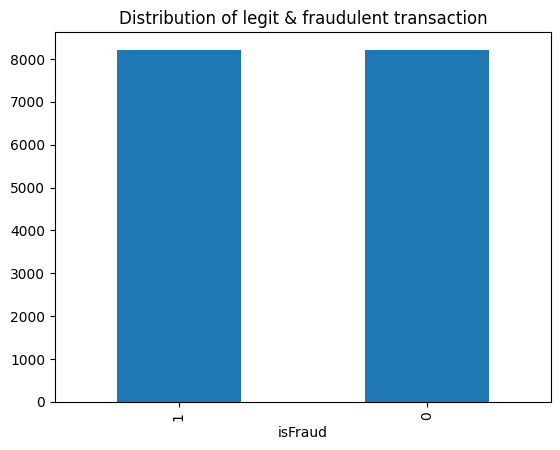

In [45]:
balanced_data = pd.concat([fraud, legit.sample(n=len(fraud), random_state=42)])
balanced_data['isFraud'].value_counts().plot(kind='bar').set_title('Distribution of legit & fraudulent transaction')

In [46]:
balanced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,deltabalanceOrig,deltabalanceDest
2,4,-0.297555,-0.288654,-0.292442,1,0.146011,-0.152896
3,1,-0.297555,-0.288654,-0.292442,1,0.146011,-0.178952
251,4,-0.293208,-0.287745,-0.292442,1,0.163912,-0.152896
252,1,-0.293208,-0.287745,-0.292442,1,0.163912,-0.185127
680,4,-0.264522,-0.281748,-0.292442,1,0.282035,-0.152896


In [47]:
X = balanced_data.drop(columns=['isFraud'], axis=1)
y = balanced_data['isFraud']
X.head()

,type,amount,oldbalanceOrg,newbalanceOrig,deltabalanceOrig,deltabalanceDest
2,4,-0.297555,-0.288654,-0.292442,0.146011,-0.152896
3,1,-0.297555,-0.288654,-0.292442,0.146011,-0.178952
251,4,-0.293208,-0.287745,-0.292442,0.163912,-0.152896
252,1,-0.293208,-0.287745,-0.292442,0.163912,-0.185127
680,4,-0.264522,-0.281748,-0.292442,0.282035,-0.152896


#Model Building:

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Decision Tree

**Pre-Built Sklearn Model**

In [49]:
dt_p = DecisionTreeClassifier(random_state=42)
dt_p.fit(X_train, y_train)

# Predict on the test set
y_pred_p = dt_p.predict(X_test)

In [50]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p))
print("Classification Report:\n", classification_report(y_test, y_pred_p))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p))

Accuracy: 0.9890444309190505
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1616   21]
 [  15 1634]]


**Self-Built Model**

In [51]:
X_train_n = X_train.to_numpy()
X_test_n = X_test.to_numpy()
y_train_n = y_train.to_numpy()
y_test_n = y_test.to_numpy()

In [54]:
# Initialize and train the decision tree
dt_s = DecisionTreeClassifierScratch()
dt_s.fit(X_train_n, y_train_n)
y_pred_s = dt_s.predict(X_test_n)

In [60]:
# Evaluation
print("Accuracy:", accuracy_score(y_test_n, y_pred_s))
print("Classification Report:\n", classification_report(y_test_n, y_pred_s))
print("Confusion Matrix:\n", confusion_matrix(y_test_n, y_pred_s))

Accuracy: 0.9911746804625685
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1620   17]
 [  12 1637]]


### 2. K-Nearest Kneighbor






**Pre-Built Model**

In [66]:
# Train a K-Nearest Neighbors model
knn_p = KNeighborsClassifier(n_neighbors=1)
knn_p.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [67]:
# Predict on the test set
y_pred_p2 = knn_p.predict(X_test)

In [68]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p2))
print("Classification Report:\n", classification_report(y_test, y_pred_p2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p2))

Accuracy: 0.9881314668289713
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1613   24]
 [  15 1634]]


**Self-Built Model**

In [78]:
# call train test here. But do not write the whole program here instead write self model class at the top of file.

###Logistic Regression

In [69]:
# Initialize and train the logistic regression model
lg_p = LogisticRegression()
lg_p.fit(X_train, y_train)

LogisticRegression()

In [71]:
#predict
y_pred_p3 = lg_p.predict(X_test)

In [72]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p3))
print("Classification Report:\n", classification_report(y_test, y_pred_p3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p3))

Accuracy: 0.9056603773584906
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1637
           1       0.95      0.86      0.90      1649

    accuracy                           0.91      3286
   macro avg       0.91      0.91      0.91      3286
weighted avg       0.91      0.91      0.91      3286

Confusion Matrix:
 [[1563   74]
 [ 236 1413]]


**Self-Built Model**

In [ ]:
# call train test here. But do not write the whole program here instead write self model class at the top of file.

### 4. Random Forest

**Pre-Built Model**

In [73]:
rf_p = RandomForestClassifier(n_estimators=100, random_state=42)
rf_p.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
y_pred_p4 = rf_p.predict(X_test)

In [76]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p4))
print("Classification Report:\n", classification_report(y_test, y_pred_p4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p4))

Accuracy: 0.9923919659160073
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1622   15]
 [  10 1639]]


**Self-Built Model**

In [77]:
# call train test here. But do not write the whole program here instead write self model class at the top of file.

#Model Evaluation:

###Decision Tree

####**Sklearn Vs Self-Built Model**

In [95]:
models = {
    "Decision Tree Sklearn": dt_p,
    "Decision Tree Self": dt_s
}

In [96]:
# Compare the performance visually using bar plots
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results = {metric: [] for metric in metrics}

In [97]:
report = classification_report(y_test, y_pred_p, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test, y_pred_p))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

report = classification_report(y_test_n, y_pred_s, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test_n, y_pred_s))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])


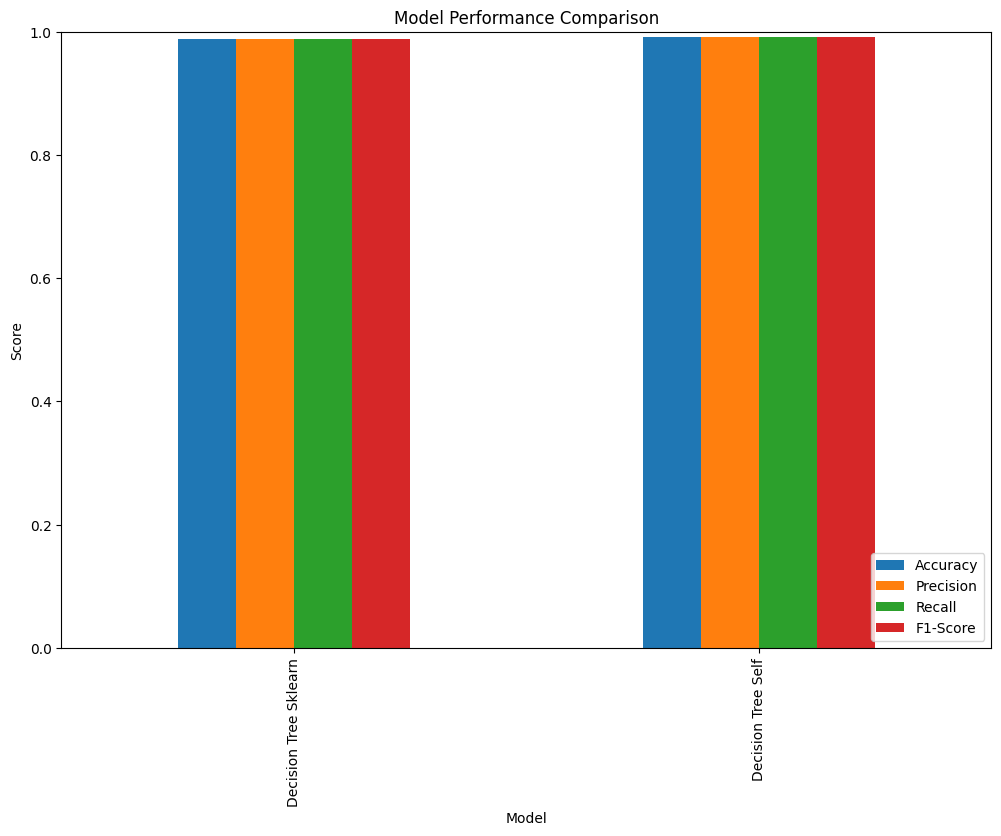

In [98]:
results_df = pd.DataFrame(results, index=models.keys())

# Plot the results
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

Both algorithms performed almost equal in terms accuracy, precision, recall, F1-score.

But the training time of sklearn is significantly lesser than self built model.

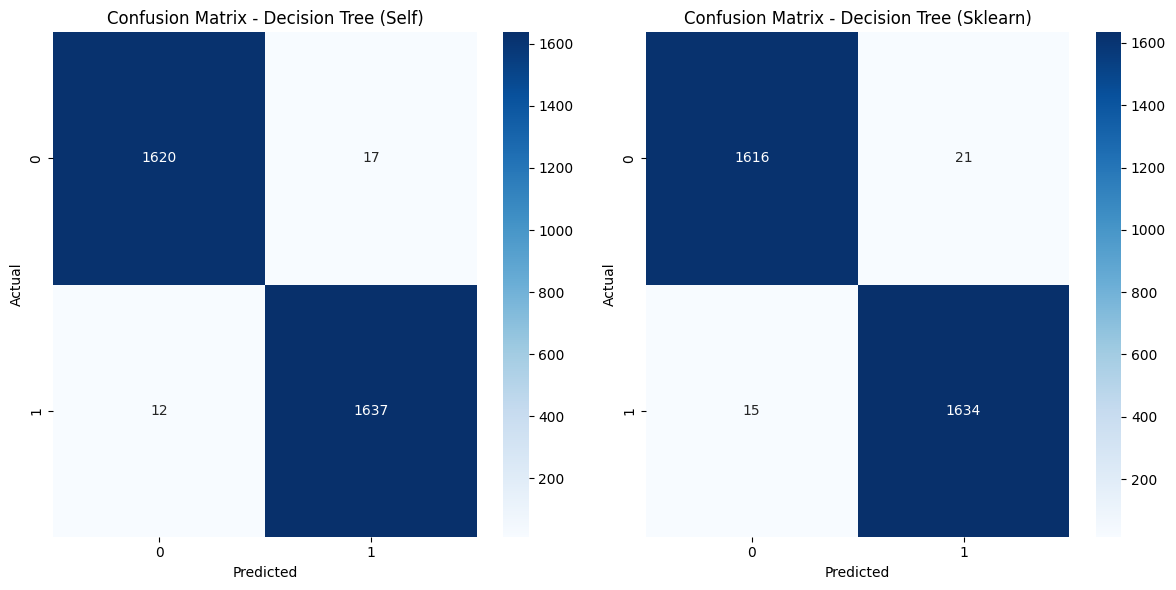

In [100]:

# Compute confusion matrices
cm_dt_s = confusion_matrix(y_test_n, y_pred_s)
cm_dt_p = confusion_matrix(y_test_n, y_pred_p)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm_dt_s, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Decision Tree (Self)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_dt_p, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Decision Tree (Sklearn)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [101]:
# Similarly do this comparasion for your models as well